In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/milk-production/monthly_milk_production.csv


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df=pd.read_csv('/kaggle/input/milk-production/monthly_milk_production.csv',parse_dates=True,index_col='Date')
df.index.freq='MS'
              

In [7]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<Axes: xlabel='Date'>

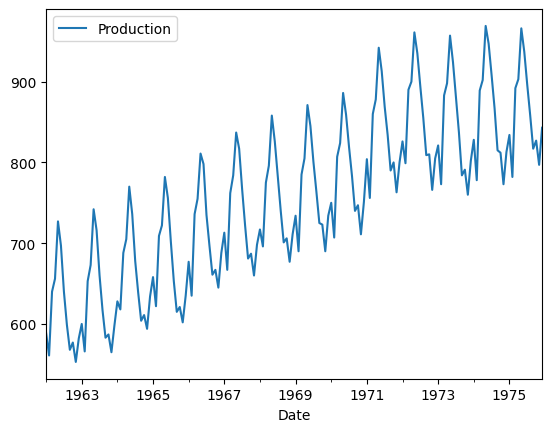

In [8]:
df.plot(legend=True)

In [9]:
from statsmodels.tsa.stattools import adfuller
adf=adfuller(df['Production'],autolag='AIC')
print("1. ADF:",adf[0])
print("2. P-Value:",adf[1])
print("3. No. of lags", adf[2])
print("4. No. of observations:" ,adf[3])
print("5. Critical Values")
for key,val in adf[4].items():
    print(key,"+",val)
    


1. ADF: -1.3038115874221308
2. P-Value: 0.6274267086030311
3. No. of lags 13
4. No. of observations: 154
5. Critical Values
1% + -3.473542528196209
5% + -2.880497674144038
10% + -2.576878053634677


SINCE THE P-VALUE IS GREATER THAN 0.05 , THUS THE ABOVE GRAPH IS SEASONAL

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

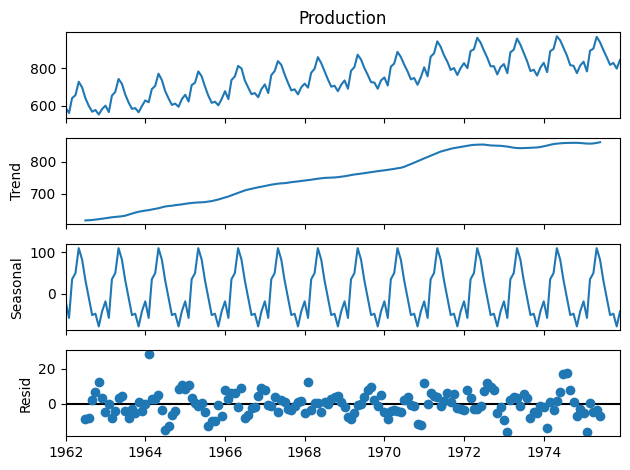

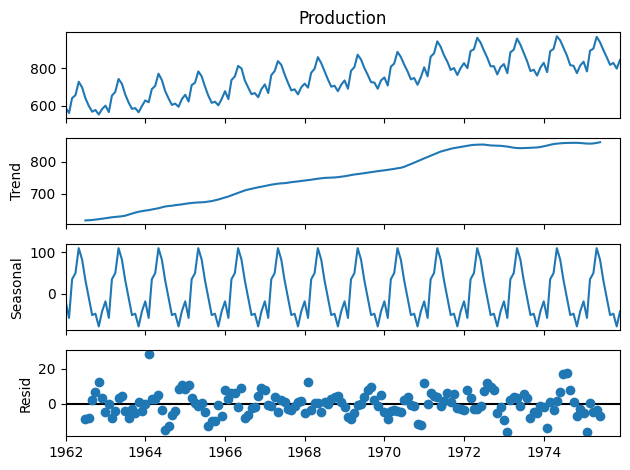

In [11]:
results=seasonal_decompose(df['Production'])
results.plot()

In [12]:
len(df)

168

In [13]:
train = df.iloc[:156]
test = df.iloc[156:]

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [15]:
df.head(),df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [16]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [17]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [22]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [23]:
X.shape

(1, 3, 1)

In [25]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [28]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [29]:

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.fit(generator,epochs=50)

Epoch 1/50
 24/144 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2499

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0970
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0267
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0191
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0086
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0058
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0095
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0051
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030
Epoch 9/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033
Epoch 10/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0038
Epoch 11/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0072
Epoch 12/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029
Epoch 13/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0040
Epoch 14/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0039
Epoch 15/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0039


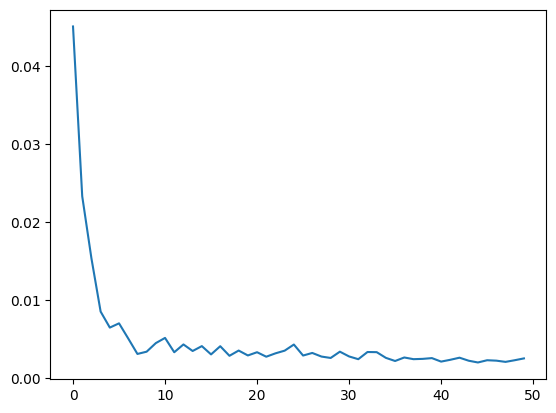

In [31]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [32]:
last_train_batch = scaled_train[-12:]

In [33]:

last_train_batch = last_train_batch.reshape((1, n_input, n_features))


In [34]:
model.predict(last_train_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


array([[0.5911548]], dtype=float32)

In [35]:
scaled_test[0]

array([0.67548077])

In [36]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [37]:
test_predictions

[array([0.5911548], dtype=float32),
 array([0.5605492], dtype=float32),
 array([0.726143], dtype=float32),
 array([0.7905309], dtype=float32),
 array([0.88762075], dtype=float32),
 array([0.8683527], dtype=float32),
 array([0.80075806], dtype=float32),
 array([0.70900214], dtype=float32),
 array([0.60467976], dtype=float32),
 array([0.5686719], dtype=float32),
 array([0.52402484], dtype=float32),
 array([0.5505474], dtype=float32)]

In [38]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [39]:
true_predictions = scaler.inverse_transform(test_predictions)

In [40]:
test['Predictions'] = true_predictions

/tmp/ipykernel_33/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [44]:
test.head()

,Production,Predictions
Date,,
1975-01-01,834,798.920403
1975-02-01,782,786.188467
1975-03-01,892,855.075489
1975-04-01,903,881.860863
1975-05-01,966,922.250231


<Axes: xlabel='Date'>

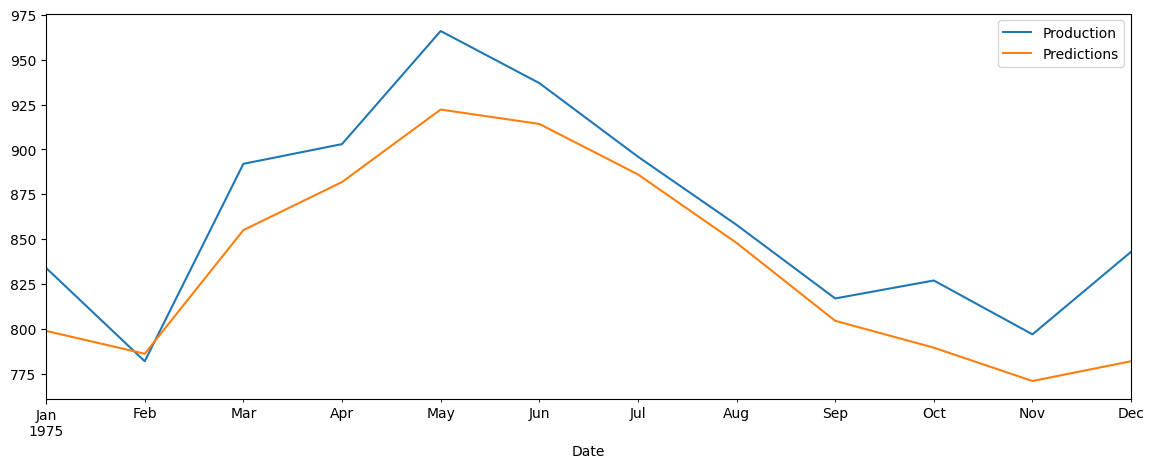

In [42]:
test.plot(figsize=(14,5))

In [43]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

31.14442511357526
